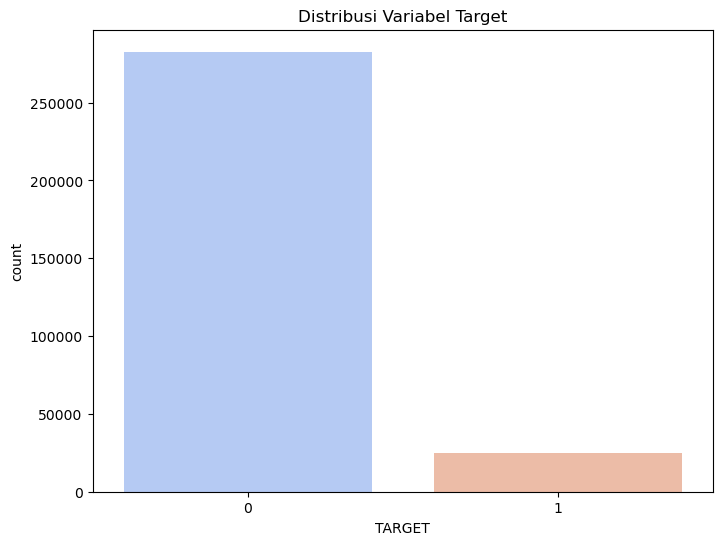

C:\Users\ASUS\AppData\Local\Temp\ipykernel_70608\1724975566.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=high_missing.index, y=high_missing.values, palette='magma')


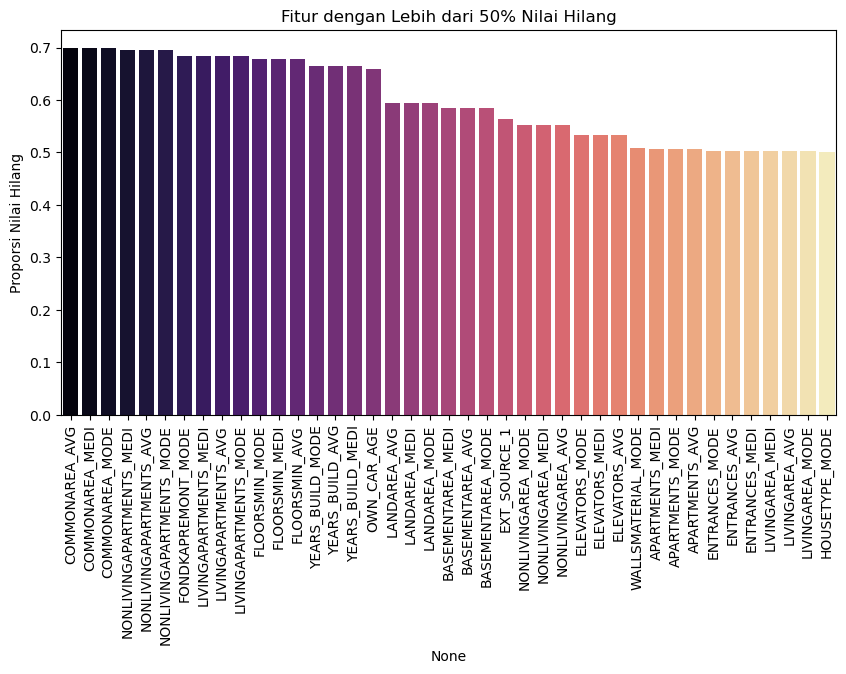

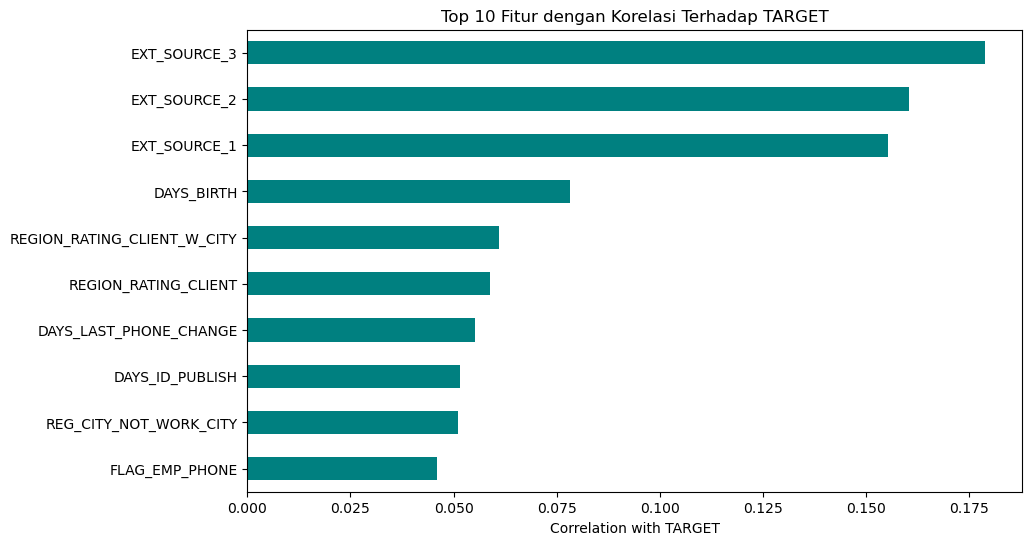

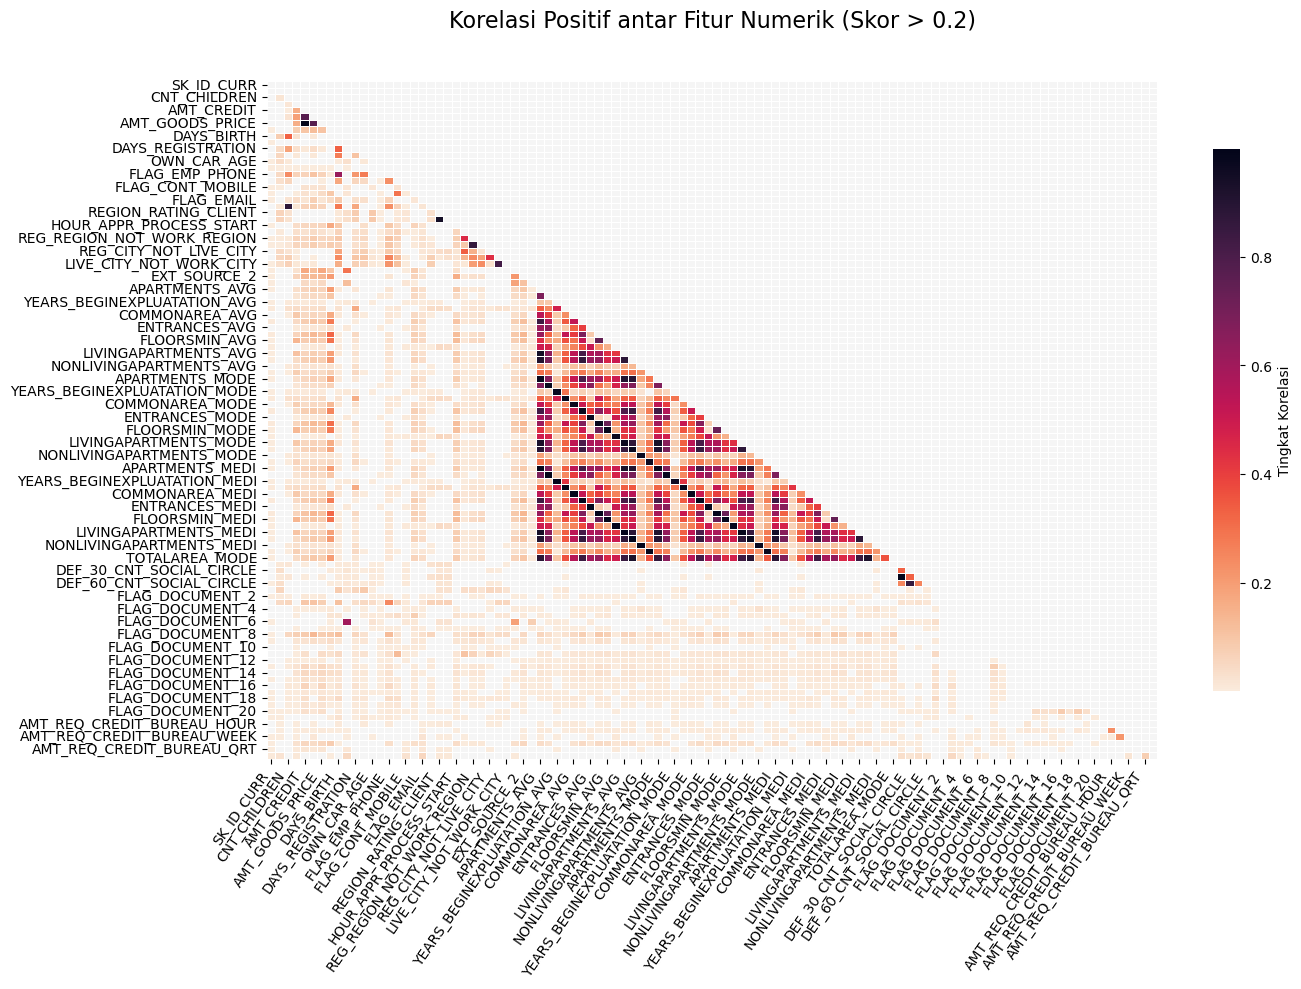

[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.154627 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4003
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 74
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.748364
ROC-AUC Regresi Logistik: 0.7395
ROC-AUC LightGBM: 0.7484

--- INSIGHT & REKOMENDASI BISNIS ---
Model LightGBM memiliki performa lebih baik dibandingkan Logistic Regression dengan nilai ROC-AUC lebih tinggi.
Rekomendasi: Gunakan LightGBM dalam sistem scoring kredit untuk meningkatkan akurasi prediksi

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
import lightgbm as lgb

def load_data(train_path):
    """Memuat dataset"""
    train_df = pd.read_csv(train_path)
    return train_df

def eda(train_df):
    """Eksplorasi Data (EDA)"""
    plt.figure(figsize=(8, 6))
    sns.countplot(x='TARGET', data=train_df, hue='TARGET', palette='coolwarm', legend=False)
    plt.title('Distribusi Variabel Target')
    plt.show()

    # Visualisasi fitur dengan nilai hilang > 50%
    missing_ratio = train_df.isnull().mean()
    high_missing = missing_ratio[missing_ratio > 0.5].sort_values(ascending=False)
    if not high_missing.empty:
        plt.figure(figsize=(10, 5))
        sns.barplot(x=high_missing.index, y=high_missing.values, palette='magma')
        plt.xticks(rotation=90)
        plt.ylabel('Proporsi Nilai Hilang')
        plt.title('Fitur dengan Lebih dari 50% Nilai Hilang')
        plt.show()
    else:
        print("Tidak ada fitur dengan lebih dari 50% nilai hilang.")

    num_cols = train_df.select_dtypes(include=[np.number]).columns
    corr_with_target = train_df[num_cols].corr()['TARGET'].drop('TARGET').abs()
    top_features = corr_with_target.sort_values(ascending=False).head(10)
    
    plt.figure(figsize=(10, 6))
    top_features.sort_values().plot(kind='barh', color='teal')
    plt.xlabel("Correlation with TARGET")
    plt.title("Top 10 Fitur dengan Korelasi Terhadap TARGET")
    plt.show()
    
    # Hitung matriks korelasi dan filter nilai negatif
    corr_matrix = train_df[num_cols].corr()
    positive_corr = corr_matrix.where(corr_matrix > 0)
    
    # Filter fitur dengan minimal satu korelasi > 0.2
    significant_cols = positive_corr.columns[positive_corr.max() > 0.2]
    filtered_corr = positive_corr.loc[significant_cols, significant_cols]
    
    # Buat mask untuk segitiga atas
    mask = np.triu(np.ones_like(filtered_corr, dtype=bool))
    
    # Visualisasi
    plt.figure(figsize=(14, 10))
    sns.heatmap(
        filtered_corr,
        mask=mask,
        cmap='rocket_r',  # Menggunakan colormap sequential
        annot=False,       # Menghilangkan angka dalam kotak
        linewidths=0.5,
        linecolor='white',
        cbar_kws={'label': 'Tingkat Korelasi', 'shrink': 0.8}
    )
    
    # Customisasi label
    plt.title('Korelasi Positif antar Fitur Numerik (Skor > 0.2)\n', fontsize=16, pad=20)
    plt.xticks(rotation=55, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    
    # Tambah grid lines untuk keterbacaan
    plt.gca().set_facecolor('#f5f5f5')
    plt.grid(False)
    plt.show()

def handle_missing_values(train_df):
    """Hapus fitur dengan >50% missing values"""
    missing_ratio = train_df.isnull().mean()
    columns_to_drop = missing_ratio[missing_ratio > 0.5].index.tolist()
    train_df = train_df.drop(columns=columns_to_drop)
    
    """Menangani nilai yang hilang dengan median hanya untuk fitur numerik"""
    num_cols = train_df.select_dtypes(include=[np.number]).columns
    num_cols = num_cols.drop('TARGET', errors='ignore')  # Hindari TARGET
    train_df[num_cols] = train_df[num_cols].fillna(train_df[num_cols].median())
    return train_df

def encode_categorical(train_df):
    """Encoding fitur kategorikal"""
    for col in train_df.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        train_df[col] = le.fit_transform(train_df[col].astype(str))
    return train_df

def preprocess_data(train_df):
    """Memilih fitur dan target, serta standarisasi fitur numerik"""
    X = train_df.drop(columns=['TARGET', 'SK_ID_CURR'])
    y = train_df['TARGET']
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled, y

def train_models(X_train, y_train, X_valid, y_valid):
    """Melatih model Logistic Regression dan LightGBM"""
    log_reg = LogisticRegression()
    log_reg.fit(X_train, y_train)
    y_pred_logreg = log_reg.predict_proba(X_valid)[:, 1]
    roc_auc_logreg = roc_auc_score(y_valid, y_pred_logreg)

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_valid = lgb.Dataset(X_valid, y_valid, reference=lgb_train)
    params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'early_stopping_rounds': 50
}
    model_lgb = lgb.train(params, lgb_train, valid_sets=[lgb_valid], num_boost_round=100)
    y_pred_lgb = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    roc_auc_lgb = roc_auc_score(y_valid, y_pred_lgb)

    return log_reg, model_lgb, roc_auc_logreg, roc_auc_lgb

def generate_insights(roc_auc_logreg, roc_auc_lgb, top_features):
    """Menganalisis hasil model dan memberikan rekomendasi bisnis"""
    print("\n--- INSIGHT & REKOMENDASI BISNIS ---")
    if roc_auc_lgb > roc_auc_logreg:
        print("Model LightGBM memiliki performa lebih baik dibandingkan Logistic Regression dengan nilai ROC-AUC lebih tinggi.")
        print("Rekomendasi: Gunakan LightGBM dalam sistem scoring kredit untuk meningkatkan akurasi prediksi risiko gagal bayar.")
    else:
        print("Logistic Regression memiliki performa lebih baik atau hampir sama dengan LightGBM.")
        print("Rekomendasi: Jika interpretasi model lebih diutamakan, gunakan Logistic Regression karena lebih mudah dijelaskan ke stakeholder.")
    
    print("\nTop 10 fitur yang paling berkorelasi dengan TARGET:")
    print(top_features)
    
    print("\n--- Analisis Fitur dan Implikasi Risiko Kredit ---")
    print("1. **Skor Kredit Eksternal (EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3)**: Fitur ini memiliki korelasi yang sangat tinggi dengan risiko gagal bayar, menunjukkan bahwa data eksternal seperti skor kredit dari pihak ketiga berperan besar dalam memprediksi stabilitas finansial pelanggan.")
    print("   * Rekomendasi: Integrasikan lebih banyak data eksternal untuk meningkatkan akurasi model.")
    print("2. **Usia (DAYS_BIRTH)**: Usia pelanggan berpengaruh signifikan terhadap risiko gagal bayar, dengan pelanggan yang lebih muda cenderung memiliki risiko lebih tinggi.")
    print("   * Rekomendasi: Buat kategori risiko yang lebih tajam berdasarkan usia pelanggan, dengan penyesuaian syarat dan bunga untuk kelompok usia yang berbeda.")
    print("3. **Wilayah (REGION_RATING_CLIENT, REGION_RATING_CLIENT_W_CITY)**: Lokasi pelanggan menunjukkan hubungan erat dengan risiko gagal bayar, dengan beberapa wilayah memiliki risiko lebih tinggi dibandingkan yang lain.")
    print("   * Rekomendasi: Lakukan analisis lebih mendalam untuk wilayah dengan risiko tinggi dan pertimbangkan strategi pinjaman yang berbeda untuk masing-masing wilayah.")
    print("4. **Tingkat Pendidikan (NAME_EDUCATION_TYPE)**: Tingkat pendidikan berpengaruh pada stabilitas ekonomi dan kemampuan membayar kredit pelanggan.")
    print("   * Rekomendasi: Segmentasikan pelanggan berdasarkan tingkat pendidikan untuk lebih memahami pola pembayaran dan kemampuan finansial mereka.")
    print("5. **Gender (CODE_GENDER)**: Pola pembayaran berdasarkan gender menunjukkan adanya perbedaan yang bisa mempengaruhi analisis risiko kredit.")
    print("   * Rekomendasi: Lakukan analisis lanjutan untuk memahami perbedaan pola pembayaran antara pria dan wanita, serta sesuaikan strategi pemasaran atau penawaran produk sesuai temuan tersebut.")

def main():
    train_df = load_data('application_train.csv')
    eda(train_df)
    train_df = handle_missing_values(train_df)
    train_df = encode_categorical(train_df)
    X_scaled, y = preprocess_data(train_df)
    X_train, X_valid, y_train, y_valid = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    log_reg, model_lgb, roc_auc_logreg, roc_auc_lgb = train_models(X_train, y_train, X_valid, y_valid)

    print(f'ROC-AUC Regresi Logistik: {roc_auc_logreg:.4f}')
    print(f'ROC-AUC LightGBM: {roc_auc_lgb:.4f}')
 
    # Dapatkan fitur dengan korelasi tertinggi terhadap TARGET
    num_cols = train_df.select_dtypes(include=[np.number]).columns
    corr_with_target = train_df[num_cols].corr()['TARGET'].drop('TARGET').abs()
    top_features = corr_with_target.sort_values(ascending=False).head(10)
    
    generate_insights(roc_auc_logreg, roc_auc_lgb,top_features)

if __name__ == "__main__":
    main()
